In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
import NSMap as ns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
from datetime import datetime
from datetime import date

%load_ext autoreload
%autoreload 2

### Bring one Newport multiwindow and one Baltic Sea multiwindow analysis together into one figure
Most of the code in this notebook is copied from the Baltic Sea and Newport analysis notebooks, so refer to those for greater readability

In [2]:
filename = "../datasets/baltic_sea_mesocosm_transformed.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
table = df.to_numpy()

In [3]:
fsize = 12

In [37]:
def makeHeatMapBaltic(results):
    nonstationarityHeatMap = np.zeros((29,29)) * np.nan
    for l, o, d, t, r in results:
        i_length = 27-(int(l / year_steps) - 2)
        i_offset = int(o / year_steps)
        # print(i_length, i_offset)
        nonstationarityHeatMap[i_length, i_offset] = d
        
    return nonstationarityHeatMap

def makeFigureBaltic(nonstationarityHeatMap, ts, name, ax):
    scaling = lengths[-1] *3.35 / 365
    
    im = ax.imshow(np.log(nonstationarityHeatMap[:-2]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(31,step = 60 / scaling))
    ax.set_yticks(30-365*np.arange(1,8)/3.35/26) # DON'T TOUCH THIS LINE
    ax.set_xticklabels([])
    ax.set_yticklabels(np.arange(1,8))
    ax.set_ylim(27,-1)
    ax.set_xlim(-1.3,32)
    
    ax.set_ylabel("Time series length (years)",fontsize=fsize)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=fsize)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(table[:,0]/365, ts,c="dodgerblue")
    axTS.set_ylabel(name, fontsize = fsize-1)
    axTS.set_xlabel("Start year",fontsize=fsize)
    axTS.set_yticks([])

    # plt.savefig(f"../Figures/baltic_sea_multiwindow_analysis/{name}_multiwindow.png", dpi=300)
    # plt.show()

In [38]:
def makeHeatMapNewport(results):
    nonstationarityHeatMap = np.zeros((25,25)) * np.nan
    for l, o, d, t, r in results:
        i_length = 24-(int(l/12) - 2)
        i_offset = int(o/12)
        nonstationarityHeatMap[i_length, i_offset] = d
    
    return nonstationarityHeatMap

def makeFigureNewport(nonstationarityHeatMap, ts, name, ax):
    # fig, ax = plt.subplots(1,figsize=(13,10))
    # fig, ax = plt.subplots(1,figsize=(8,8))
    im = ax.imshow(np.log(nonstationarityHeatMap[:-3]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(0,26+1,step=4))
    ax.set_xlim(-1.08,27.7)

    ax.set_ylabel("Time series length (years)",fontsize=fsize)
    ax.set_yticks(np.arange(26, step=4))
    ax.set_yticklabels(np.flip(np.arange(2,26+1, step=4)))

    # drawBracket(2008, 9, ax)
    # drawBracket(2014, 8, ax)
    # drawBracket(1996, 26, ax)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=fsize)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(np.linspace(1996.264,2022.335,num=312), ts,c="dodgerblue")
    axTS.set_xticks(np.arange(1996,2022+1,step=4))
    axTS.set_yticks([])
    axTS.set_ylabel(f"{name}", fontsize = fsize-1, style = "italic")
    axTS.set_xlabel("Start year",fontsize=fsize)
    
    ax.set_ylim(22, -1)

    # plt.savefig(f"../Figures/newport_multiwindow_analysis/{name}_multiwindow.png", dpi=300)

def drawBracket(start_year, length, ax):
    start_index = start_year - 1996
    length_index = 26 - length
    ax.plot(np.array([start_index, start_index + length ]),
            np.ones(2)*length_index, c="black")

In [47]:
# Convert the delta values for each subseries into a square matrix
# which is plotted using matplotlib's imshow.
def makeHeatMapPortal(results):
    year_steps = 24
    
    nonstationarityHeatMap = np.zeros((20, 20)) * np.nan
    for l, o, d, t, r in results:
        i_length = 21-(int(l / year_steps) - 2)
        i_offset = int(o / year_steps)
        
        nonstationarityHeatMap[i_length, i_offset] = d
        
    return nonstationarityHeatMap

# Make the figure
def makeFigurePortal(nonstationarityHeatMap, ts, name, ax):
    
    filenames = {"Dipodomys merriami" : "Figure_S17",
                 "C. penicillatus" : "Figure_S18",
                 "Dipodomys ordii" : "Figure_S19"}
    
    year_steps = 24
    maxLen = ts.shape[0]
    lengths = np.arange(year_steps*4,maxLen+1,step=year_steps)
    scaling = lengths[-1]
    
    # im = ax.imshow(np.zeros(nonstationarityHeatMap[:-2].shape), cmap=cm.Greys)
    im = ax.imshow(np.log(nonstationarityHeatMap+1), cmap=custom_cmap)
    ax.set_xticks(29/24 + 5 * np.arange(8))
    ax.set_yticks(np.arange(21, step=5))
    ax.set_xticklabels([])
    ax.set_yticklabels((np.flip(lengths)[::5] / 12).astype(int))
    ax.set_ylim(20,-1)
    ax.set_xlim(-1.1, 24.25)
    
    ax.set_ylabel("Time series length (years)",fontsize=fsize)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=fsize)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    sample_time = np.linspace(7/12 + 1977, 7/12 + 2023, num = 12 * 46 + 1)
    
    axTS.plot(sample_time, ts,c="dodgerblue")
    axTS.set_ylabel(name,fontsize=fsize-1, style="italic")
    axTS.set_xlabel("Start year",fontsize=fsize)
    # axTS.set_xticks(table[::4,0])
    axTS.set_yticks([])
    
    # plt.savefig(f"../figures_eps/portal_multiwindow/{filenames[name]}.eps", format="eps", bbox_inches="tight", transparent=False, facecolor="white")
    # plt.show()
    
def get_species_plot_series(species, plot_num):
    total_months_elapsed = 46 * 12 + 1
    month_counter = 7
    year_counter = 1977

    table = df[["month", "day", "year", "species", "period", "plot"]].query(f"period >= 0")
    starting_date = date(table.head(1)["year"], table.head(1)["month"], table.head(1)["day"])
    
    # table_species = table.query(f"species == \"{species}\"")[["month", "day", "year"]].to_numpy(dtype=np.int64)
    table_species = table.query(f"plot == \"{plot_num}\" and species == \"{species}\"")[["day", "month", "year"]].to_numpy(dtype=np.int64)
    # table_species = table.query(f"species == \"{species}\"")[["month", "year"]].to_numpy(dtype=np.int64)
    
    trapping_days = df_trapping_dates.query("sampled == 1")[["day", "month", "year"]].to_numpy()

    ts = np.zeros(total_months_elapsed) * np.NAN
    ts_i = 0
    while not (month_counter > 7 and year_counter > 2023):
        sampling_day_indices = np.logical_and(trapping_days[:,1] == month_counter, trapping_days[:,2] == year_counter)
        number_of_samples_this_month = len(np.unique(trapping_days[sampling_day_indices], axis=0))
        
        if number_of_samples_this_month > 0:
            is_sample_valid = np.logical_and(table_species[:,1] == month_counter, table_species[:,2] == year_counter)
            ts[ts_i] = np.sum(table_species[is_sample_valid]) / number_of_samples_this_month

        ts_i += 1
        month_counter += 1
        if month_counter > 12:
            month_counter = 1
            year_counter += 1

    t = np.linspace(0,1, num= total_months_elapsed)
    return (ts, t)
    
# fetches the sum of all species from a particular control site
def get_species_control_series(species):
    control_only_plots = [4 , 11, 14, 17]
    
    ts, t = get_species_plot_series(species, control_only_plots[0])
    for plot_id in control_only_plots[1:]:
        ts += get_species_plot_series(species, plot_id)[0]
    
    return (ts, t)

In [48]:
# Convert the delta values for each subseries into a square matrix
# which is plotted using matplotlib's imshow.
def makeHeatMapSeabird(results):
    year_steps = 1
    nonstationarityHeatMap = np.zeros((21,21)) * np.nan
    for l, o, d, t, r in results:
        i_length = 28-(int(l / year_steps) - 2)
        i_offset = int(o / year_steps)
        
        nonstationarityHeatMap[i_length, i_offset] = d
        
    return nonstationarityHeatMap

# Make the figure
def makeFigureSeabird(nonstationarityHeatMap, ts, name, ax):
    name_to_fig_title = {"Common\nMurre" : "Figure_S15",
                         "Brandt's Cormorant": "Figure_S16"}
    
    year_steps = 1
    maxLen = ts.shape[0]
    lengths = np.arange(year_steps*10,maxLen+1,step=year_steps)
    scaling = lengths[-1]

    # im = ax.imshow(np.zeros(nonstationarityHeatMap[:-2].shape), cmap=cm.Greys)
    im = ax.imshow(np.log(nonstationarityHeatMap+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(27, step=5))
    ax.set_yticks(np.arange(21, step=5))
    ax.set_xticklabels([])
    ax.set_yticklabels(np.flip(lengths[::5]))
    ax.set_ylim(21,-1)
    ax.set_xlim(-1.5,30.5)
    
    ax.set_ylabel("Time series length (years)",fontsize=fsize)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=fsize)
    
    axTS = divider.append_axes('bottom', size='30%', pad=0.1)
    
    axTS.plot(table[:,0], ts,c="dodgerblue")
    axTS.set_ylabel(name,fontsize=fsize-1)
    axTS.set_xlabel("Start year",fontsize=fsize)
    axTS.set_xticks(table[::5,0])
    axTS.set_yticks([])

In [49]:
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba])
custom_cmap.set_bad("white", 1)

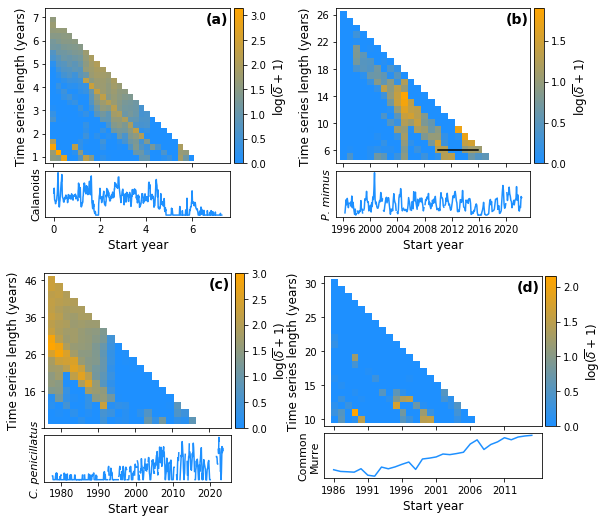

In [51]:
text_padding = 0.01 # -0.075

# Baltic Sea
filename = "../datasets/baltic_sea_mesocosm_transformed.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
table = df.to_numpy()

fig, ax = plt.subplots(2, 2, figsize=(8.5,7.5))

index = 0
year_steps = 27

species_baltic = "Calanoids"
results = np.loadtxt(f"../results/baltic_sea_multiwindow/{species_baltic}_time_window.csv",
                     delimiter=",")
lengths = np.unique(results[:,0])

ts = ns.standardize(table[:,index+1])
nonstationarityHeatMap = makeHeatMapBaltic(results)
makeFigureBaltic(nonstationarityHeatMap, ts, species_baltic, ax[0, 0])

# Newport Pseudocalanus
results = np.loadtxt("../results/newport_multiwindow/pseudocalanus_time_window.csv", delimiter=",")

# Load the time series for Pseudocalanus, the most abundant Newport species
table = np.loadtxt("../datasets/newport_aggregated_series.csv", delimiter=",")
ts = table[:,0]

nonstationarityHeatMap = makeHeatMapNewport(results)
makeFigureNewport(nonstationarityHeatMap, ts, "P. mimus", ax[0, 1])

# Portal Dataset
filename = "..\Datasets\Portal_rodent.csv"
filename_trapping_dates = "..\Datasets\Portal_rodent_trapping.csv"

df = pd.read_csv(filename, encoding="utf-8", na_filter=False)
df = df.astype({"plot":str})
df_trapping_dates = pd.read_csv(filename_trapping_dates, encoding="utf-8", na_filter=False)

ts_raw, t = get_species_control_series("PP")
ts = ns.standardize(np.sqrt(ts_raw))

results = np.loadtxt(f"../results/portal_rodent_analysis/PP_time_window.csv",
                         delimiter=",")

nonstationarityHeatMap = makeHeatMapPortal(results)
makeFigurePortal(nonstationarityHeatMap, ts, "C. penicillatus", ax[1, 0])

drawBracket(2010, 6, ax[0, 1])

# Seabird Analysis

filename = "../datasets/birddata_cleaned.csv"
df_raw = pd.read_csv(filename, encoding="utf-8", na_filter=True)
df = df_raw[["Year","Common murre Total", "Brandt's cormorant Total"]]
table = df.to_numpy(dtype=np.float64)

t = table.T[0,:].copy()
t = (t - np.min(t)) / np.ptp(t)

common_murre_series = ns.standardize(np.sqrt(table.T[1,:]))

results = np.loadtxt(f"../results/seabird_analysis/common_murre_time_window.csv",
                         delimiter=",")

nonstationarityHeatMap = makeHeatMapSeabird(results)
makeFigureSeabird(nonstationarityHeatMap, common_murre_series, "Common\nMurre", ax[1, 1])

ax[0, 0].text(1 - text_padding, 1 - text_padding*3, "(a)", size=fsize+2, rotation=0, 
            horizontalalignment="right", verticalalignment="top", fontweight="bold",
            transform=ax[0, 0].transAxes)
ax[0, 1].text(1 - text_padding, 1 - text_padding*3, "(b)", size=fsize+2, rotation=0, 
            horizontalalignment="right", verticalalignment="top", fontweight="bold",
            transform=ax[0, 1].transAxes)
ax[1, 0].text(1 - text_padding, 1 - text_padding*3, "(c)", size=fsize+2, rotation=0, 
            horizontalalignment="right", verticalalignment="top", fontweight="bold", 
            transform=ax[1, 0].transAxes)
ax[1, 1].text(1 - text_padding, 1 - text_padding*3, "(d)", size=fsize+2, rotation=0, 
            horizontalalignment="right", verticalalignment="top", fontweight="bold",
            transform=ax[1, 1].transAxes)

plt.tight_layout()
plt.savefig("../figures_eps/Figure_5.eps", format="eps")